Machine learning model for predicting fuel consumption.

Hyperparameter tuning and training of various linear and tree-based algorithms.

Comparison of optimally tuned models.

Perform model tuning and validation on splits of 'train' set (years 2019, 2020).

Perform final model testing on 'test' set (year 2021).

Input(s): 
- df_ml_[variant]_train.csv
- df_ml_[variant]_test.csv

Output(s): 
- Git Untracked Data:
    - Model dataframes with fitted estimators after certain steps
        - _mdl_df_base.pkl
        - _mdl_df_best.pkl
        - _mdl_df_kf.pkl
        - _mdl_df_compare.pkl
- Git Tracked Data:
    - parameters: _params.csv
    - stats comparisons for residual and fuel consumption: e.g. _best_fc.csv
    - feature importance rankings: _FI.csv    

## Preamble

In [80]:
import os
import string
import sys
# from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from xgboost import XGBRegressor
sys.path.append("../code/.")
from sklearn.compose import ColumnTransformer, make_column_transformer
# from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    # RandomizedSearchCV,
    # cross_val_score,
    # cross_validate,
    # train_test_split,
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
# from sklearn.tree import DecisionTreeRegressor
# from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import r2_score, mean_squared_error #, PredictionErrorDisplay
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import LeaveOneOut, LeavePOut, KFold
import seaborn as sns
import pickle # for saving models
from sklearn.inspection import permutation_importance # for permutation feature importance
import time #for timing


## Global Settings

In [81]:
tol_type = 'abs' # 'rel' or 'abs' tolerance type for subsetting 'valid' data based on distance discrepancy
outlier_threshold = 3 # number of standard deviations from the mean to consider a point an outlier
feature_set = 'm4dd' # feature set to use (defined herein)
validation_stats = ['r2', 'corr', 'mse', 'mae', 'mape']
cv_folds = 5
cv_scoring = 'r2'
max_cores = 6
eval_folds = 100 # number of folds for evaluation

sns.set_palette('bright') # deep, dark, bright, colorblind
datapath = 'Machine Learning/data/'
readdatapath = 'src/tracked_data/'
trackeddatapath = 'Machine Learning/tracked_data/'
plotpath = 'Machine Learning/plots/'
fileprefix = 'ML_FC_F' + feature_set + '_' 
model_df_filename = 'mdl_df'

start_time = time.time()

param_vars = [
    'tol_type',
    'outlier_threshold',
    'feature_set',
    'cv_folds',
    'cv_scoring',
    'eval_folds',
    'datapath',
    'trackeddatapath',
    'plotpath',
    'fileprefix',
    'model_df_filename']

if os.path.exists(trackeddatapath + fileprefix + 'params.csv'):
    sys.exit('File already exists. Delete params csv file to overwrite all related data.')


pd.DataFrame(
    [(i, globals()[i]) for i in param_vars],
    columns = ['parameter', 'value']
    ).to_csv(
        trackeddatapath + fileprefix + 'params.csv',
        index = False)

print(f"Started at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}")

Started at: 2024-03-23 23:23:03


### Functions

In [82]:
def col_search(searchkey):
    """
    Search for column names containing a given string and print summary statistics. (case insensitive)
    """
    colname_matches = [col for col in df_ml.columns if searchkey.lower() in col.lower()]
    if len(colname_matches) > 0:
        print(colname_matches)
        df_ml[colname_matches].describe()
        for col in colname_matches:
            if df_ml[col].nunique() <= 10:
                print(col)
                print(df_ml[colname_matches].value_counts())
    else:
        print('No matches found')

def plot_45deg_line(x, y):
    """
    Create a two-way plot with a 45-degree line.
    """
    upper = max(x.max(), y.max()) + 0.1
    lower = min(x.min(), y.min()) - 0.1
    x0 = np.linspace(lower, upper, 100)
    plt.plot(x0, x0, color='black', label='x=y')

def two_way_plot(x, y, data=None, hue=None, alpha=0.5, title=None, xlabel=None, ylabel=None, legend_title=None, regline=False, savepath=None):
    """
    Create a two-way plot with a regression line.
    """
    plt.figure(figsize=(10, 10))
    sns.scatterplot(data=data, x=x, y=y, hue=hue, alpha=alpha)
    if regline:
        sns.regplot(data=data, x=x, y=y, scatter=False, line_kws={'linestyle':'dashed'}, label='regression line', color='red')
    if data is None:
        plot_45deg_line(x, y)
    else:
        plot_45deg_line(data[x], data[y])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title=legend_title)
    if savepath:
        plt.savefig(savepath)
    plt.show()

def plot_45deg_line_new(x, y, ax):
    """
    Create a two-way plot with a 45-degree line.
    """
    upper = max(x.max(), y.max()) + 0.1
    lower = min(x.min(), y.min()) - 0.1
    x0 = np.linspace(lower, upper, 100)
    ax.plot(x0, x0, color='black', label='x=y')

def two_way_plot_new(x, y, data=None, hue=None, alpha=0.5, title=None, xlabel=None, ylabel=None, legend_title=None, regline=False, savepath=None):
    """
    Create a two-way plot with a regression line.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.scatterplot(data=data, x=x, y=y, hue=hue, alpha=alpha, ax=ax)
    if regline:
        sns.regplot(data=data, x=x, y=y, scatter=False, line_kws={'linestyle':'dashed'}, label='regression line', color='red', ax=ax)
    if data is None:
        plot_45deg_line_new(x, y, ax=ax)
    else:
        plot_45deg_line_new(data[x], data[y], ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title=legend_title)
    if savepath:
        plt.savefig(savepath)
    plt.show()
    return ax

# def make_estimator_default(scaling, mdlclass):
#     if scaling:
#         estimator = make_pipeline(preprocessor_scaling, mdlclass)
#     elif ~scaling:
#         estimator = make_pipeline(preprocessor_noscaling, mdlclass)
#     return estimator

def make_estimator(scaling, classname, params=None):
    if params is None:
        if classname == 'LinearRegression':
            estimator = make_pipeline(preprocessor_noscaling_drop, globals()[classname]())
        elif scaling:
            estimator = make_pipeline(preprocessor_scaling, globals()[classname]())
        elif ~scaling:
            estimator = make_pipeline(preprocessor_noscaling, globals()[classname]())
    else:
        if scaling:
            estimator = make_pipeline(preprocessor_scaling, globals()[classname](**params))
        elif ~scaling:
            estimator = make_pipeline(preprocessor_noscaling, globals()[classname](**params))
    return estimator
    
def MAE(y_true, y_pred):
    """
    Calculate mean absolute error.
    """
    return np.mean(np.abs(y_true - y_pred))
                   
def MAPE(y_true, y_pred):
    """
    Calculate mean absolute percentage error.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true))

def corr2(x, y):
    """
    Calculate the correlation coefficient.
    """
    return np.corrcoef(x, y)[0, 1]

def calculate_stats(y_true, y_pred, data=None, stats=None):
    """
    Create a dictionary of statistics for a model.
    """
    if data is not None:
        y_true = data[y_true]
        y_pred = data[y_pred]

    stats_dict = {}
    names_dict = {}
    defined_stats = {
        'r2': (r2_score, 'R²'),
        'corr': (corr2, 'Correlation'),
        'mse': (mean_squared_error, 'MSE'),
        'mae': (MAE, 'MAE'),
        'mape': (MAPE, 'MAPE')
    }
    stats = [stat for stat in stats if stat in defined_stats]
    for stat in stats:
        stats_dict[stat] = defined_stats[stat][0](y_true, y_pred)
        names_dict[stat] = defined_stats[stat][1]
    return {'stats' : stats_dict, 'names' : names_dict}    

def create_legend_title(stats_dict):
    """
    Create a legend title for a plot based on a dictionary of statistics.
    """
    legend_title = ''
    for key in stats_dict['stats']:
        legend_title += f"{stats_dict['names'][key]}: {round(stats_dict['stats'][key],5)}\n"
    return legend_title

def format_cv_results(grid_search):
    """
    Format the results of a grid search as a pandas DataFrame.
    """
    cv_results = pd.DataFrame(grid_search.cv_results_)[['param_gradientboostingregressor__learning_rate', 'param_gradientboostingregressor__max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')
    # shorten column names
    cv_results.columns = cv_results.columns.str.removeprefix('param_gradientboostingregressor__')
    cv_results.columns = cv_results.columns.str.replace('_score', '_' + cv_scoring)
    print(f"Model: { grid_search.estimator.named_steps['gradientboostingregressor'].__class__.__name__ }")
    return cv_results

# def model_comparison_table(stats_to_compare, params=None):
#     """
#     Create a pandas DataFrame of statistics for multiple models.
#     Args:
#         stats_to_compare: dictionary of tuples of statistics dictionaries and models
#     Returns:
#         pandas DataFrame
#     """
#     for key, value in stats_to_compare.items():
#         value[0]['stats']['model'] = key
#         if params is not None:
#             for param in params:
#                 try:
#                     value[0]['stats'][param] = value[1][-1].get_params()[param]
#                 except:
#                     value[0]['stats'][param] = np.nan

#     compare_df = pd.DataFrame([value[0]['stats'] for key, value in stats_to_compare.items()]).set_index('model')
#     return compare_df

def tribble(columns, *data):
    return pd.DataFrame(
        data=list(zip(*[iter(data)]*len(columns))),
        columns=columns
    )

def model_stats_comparison_table(stats_col, params_col, estimator_col, mdl_df):
    """
    Create a pandas DataFrame of statistics for multiple models.
    Args: 
        stats_col: name of column containing statistics
        estimator_col: name of column containing fitted estimators
    Returns:
        pandas DataFrame
    """

    compare_df = mdl_df.loc[:, [stats_col, estimator_col, params_col, 'class_name']]
    # unpack stats column
    compare_df[stats_col] = compare_df[stats_col].apply(lambda x: x['stats'])

    # create column for each statistic
    for key in compare_df[stats_col].iloc[0].keys():
        compare_df[key] = compare_df[stats_col].apply(lambda x: x[key])

    # # add model parameters from fitted estimator
    # compare_df['params'] = compare_df.apply(lambda row: row[estimator_col].named_steps[row['class_name'].lower()].get_params(), axis=1)
    # # filter the parameters to the ones in params_col
    # compare_df['params'] = compare_df.apply(lambda row: filter_params(row, params_col, 'params'), axis=1)
    compare_df['params'] = compare_df.apply(lambda row: extract_filter_params(row, estimator_col, params_col), axis=1)

    return compare_df.drop([stats_col, estimator_col, params_col], axis=1)

def extract_filter_params(row, estimator_col, params_col_mask): 
    """ 
    Extract and filter the parameters to the ones in params_col and drop parameter name prefix.
    Args:
        row: pandas DataFrame row
        estimator_col: name of column containing fitted estimators
        params_col_mask: name of column containing parameters to keep (should be without model name prefix)
    """
    params = row[estimator_col].named_steps[row['class_name'].lower()].get_params()
    if row[params_col_mask] is None:
        return None
    else:
        return {k.replace(row['class_name'].lower() + '__', ''): v for k, v in params.items() if k in row[params_col_mask].keys()}

# def filter_params(row, params_col, params_col_mask): 
#     """ 
#     Filter the parameters to the ones in params_col and drop parameter name prefix.
#     """
#     if row[params_col_mask] is None:
#         return None
#     else:
#         return {k.replace(row['class_name'].lower() + '__', ''): v for k, v in row[params_col].items() if k in row[params_col_mask].keys()}
    
def loo_evaluation(estimator):
    """
    Performs leave-one-out evaluation and returns the predicted residuals.
    """
    loo_prediction = np.zeros(len(y))

    for train_index, val_index in loo.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        estimator.fit(X_train, y_train)
        loo_prediction[val_index] = estimator.predict(X_val)
    
    return loo_prediction

def kfold_evaluation(estimator, name):
    """
    Performs k-fold evaluation and returns the predicted residuals.
    """
    print(f"Starting evaluating {name} at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}")
    kf_prediction = np.zeros(len(y))

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        estimator.fit(X_train, y_train)
        kf_prediction[val_index] = estimator.predict(X_val)
    
    return kf_prediction

def FI_plot(FI, model_name):
    FI_df = pd.DataFrame(FI.importances, index = features).assign(mean=lambda df: df.mean(axis=1)).sort_values('mean')
    plt.figure(figsize=(10, 10))
    plt.boxplot(
        FI_df.drop(columns='mean').T,
        vert=False,
        labels=np.array(FI_df.index),
    )
    plt.title('Permutation Importances: ' + model_name)
    plt.savefig(plotpath + fileprefix + 'FI_perm_' + model_name + '.png')
    plt.show()

## Data Validation and Preprocessing

### Load

In [83]:
df_ml = pd.read_csv(readdatapath + "df_ml_" + tol_type + "_train.csv", low_memory=False)

# for nicer colors when plotting
df_ml = df_ml.sort_values('year')
df_ml['year_str'] = df_ml['year'].astype(str) 

##### Column name search


In [84]:
col_search('MRV')

['MRV.EU.distance', 'MRV.method.a', 'MRV.method.b', 'MRV.method.c', 'MRV.method.d', 'MRV.verifier.country', 'MRV.verifier.name']
MRV.method.a
Series([], Name: count, dtype: int64)
MRV.method.b
Series([], Name: count, dtype: int64)
MRV.method.c
Series([], Name: count, dtype: int64)
MRV.method.d
Series([], Name: count, dtype: int64)
MRV.verifier.country
Series([], Name: count, dtype: int64)


In [85]:

df_ml.loc[:, df_ml.columns.str.contains('Type', case=False)].describe(include='all')

,Main.Engine.Fuel.Type,Type,Old.Type,Owner.Main.Vessel.Type,Alternative.Fuel.Types,Fleet.Type,Self.Unloader.Type,BWMS.Technology.Type,Hull.Type,Alternative.Fuel.Type.Ready
count,1281,1281,1,1272,0.0,1281,4,948,30,0.0
unique,4,5,1,16,NaN,1,1,11,2,NaN
top,VLS IFO,Bulk Carrier,Products,Bulker,NaN,Bulkers,Conveyor,FILTRATION - ELECTROLYSIS (ELECTRO-CHLORINATIO...,D/Hull,NaN
freq,1134,1103,1,319,NaN,1281,4,392,28,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
df_ml['Type'].value_counts(dropna=False)

Type
Bulk Carrier          1103
Open Hatch Carrier     172
Chip Carrier             4
Ore Carrier              1
Cement Carrier           1
Name: count, dtype: int64

### Stats


In [87]:
raw_mean = df_ml['residual'].mean()
raw_std = df_ml['residual'].std()
print(f'Raw Data: \n observations: {len(df_ml)} \n target mean: {raw_mean} \n target sd: {raw_std}')

stats_raw = calculate_stats('log_report_fc', 'log_cal_fc', df_ml, validation_stats)

Raw Data: 
 observations: 1281 
 target mean: -0.05601808721490245 
 target sd: 0.6720487677515353


#### Scatter plot of reported vs calculated fuel consumption

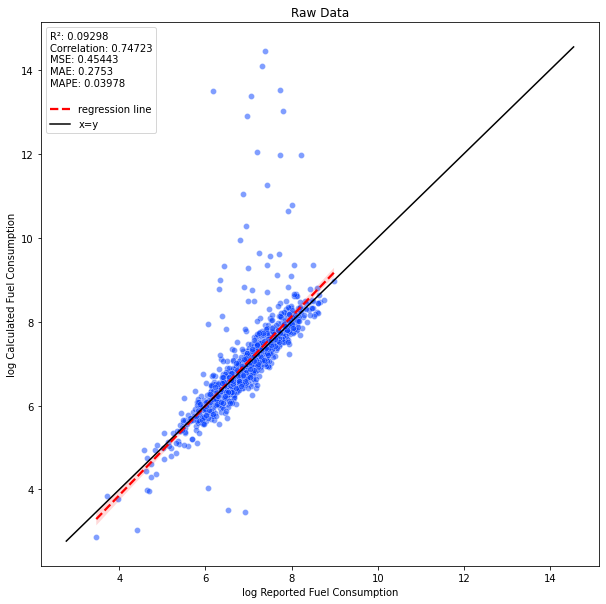

In [88]:
two_way_plot(
     'log_report_fc',
     'log_cal_fc',
     df_ml,
     title='Raw Data',
     xlabel='log Reported Fuel Consumption',
     ylabel='log Calculated Fuel Consumption',
     legend_title=create_legend_title(stats_raw),
     regline=True,
     savepath=plotpath + fileprefix + 'twoway_fc_raw.png')

#### Scatter plot of reported vs calculated fuel consumption by year using two_way_plot

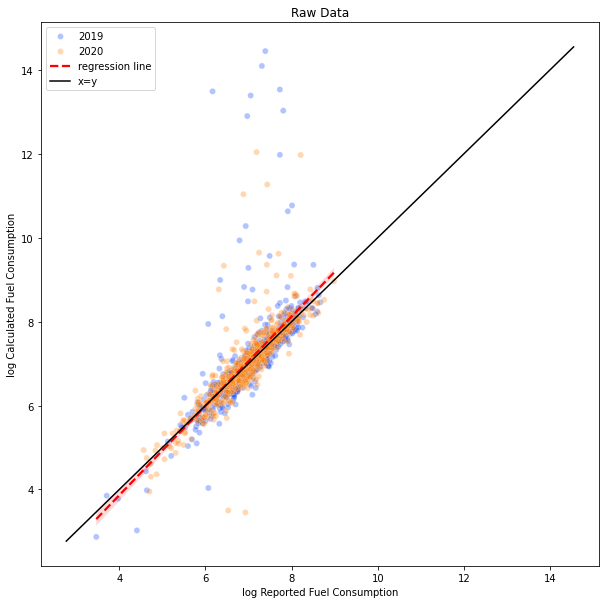

In [89]:
two_way_plot(
    'log_report_fc',
    'log_cal_fc',
    df_ml,
    hue='year_str',
    alpha=0.3,
    title='Raw Data',
    xlabel='log Reported Fuel Consumption',
    ylabel='log Calculated Fuel Consumption',
    regline=True,
    savepath=plotpath + fileprefix + 'twoway_fcbyyear_raw.png')

### Outliers

#### Explore outliers

In [90]:
df_ml['outlier'] = ~df_ml['residual'].between(
    raw_mean - outlier_threshold * raw_std,
    raw_mean + outlier_threshold * raw_std,
    inclusive='neither')
# df_ml.loc[df_ml['outlier'],:]


In [91]:
df_ml['outlier'].value_counts()

outlier
False    1256
True       25
Name: count, dtype: int64

In [92]:
# compare means of outliers and non
df_ml.loc[:, ['outlier'] + df_ml.select_dtypes(include=[np.number]).columns.tolist()].groupby('outlier').agg('mean')

,CVN,IMO.Number,mmsi,Built.Year,LDT,Demo.Price.LDT,Dwt,Beam.Mld..m.,Draught..m.,Price..NB.,...,cal_fc,port_frac,longest_jump,missing_frac_sea,age,residual,log_report_fc,log_cal_fc,distance_difference,distance_difference_rel
outlier,,,,,,,,,,,,,,,,,,,,,
False,1.655656e+07,9.498540e+06,4.370007e+08,2010.109873,11762.325000,524.5,67677.26672,32.388153,12.776879,36.085547,...,1419.981542,0.401101,2143.981513,0.253901,9.424363,0.009372,6.978592,6.969219,-46.273527,-0.008031
True,1.815732e+07,9.468790e+06,4.208973e+08,2009.520000,10464.666667,NaN,49592.52000,30.599200,11.712400,24.833333,...,281092.648031,0.469845,2187.974761,0.248334,9.840000,-3.341239,7.113545,10.454784,-46.550225,-0.004184


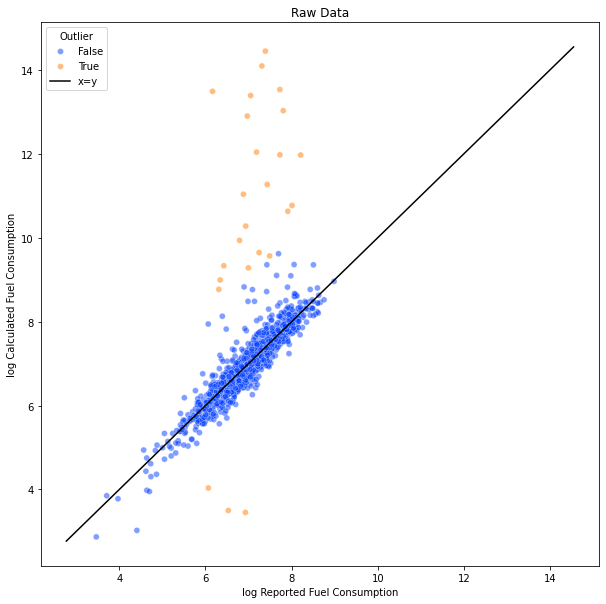

In [93]:
two_way_plot(
     'log_report_fc',
     'log_cal_fc',
     df_ml,
     hue='outlier',
     title='Raw Data',
     xlabel='log Reported Fuel Consumption',
     ylabel='log Calculated Fuel Consumption',
     legend_title='Outlier',
     regline=False,
     savepath=plotpath + fileprefix + 'twoway_fc_raw.png')

<Axes: xlabel='Dwt', ylabel='Proportion'>

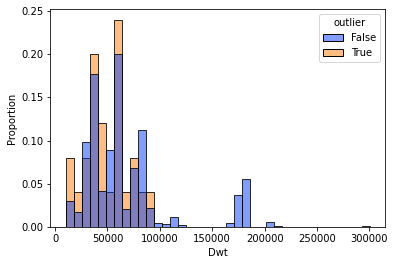

In [94]:
# Compare distributions for a given variable
sns.histplot(data=df_ml, x='Dwt', hue='outlier', stat='proportion', common_norm=False)

In [95]:
# check largest correlates
(
    df_ml
    .corr(numeric_only=True)
    .loc[:, ['outlier']]
    .assign(abs_corr=lambda x: abs(x))
    .sort_values('abs_corr', ascending=False)
    .head(30)
    )


,outlier,abs_corr
outlier,1.000000,1.000000
residual,-0.689936,0.689936
cal_fc,0.514948,0.514948
log_cal_fc,0.478083,0.478083
Dwt.per.TEU,0.270971,0.270971
TEU,-0.153390,0.153390
Arctic.Deployment..Time.in.Last.12.Months....,0.137609,0.137609
FEU.Total.Cap,-0.133763,0.133763
Laden.Speed..knots.,-0.129759,0.129759
Ballast.Speed..knots.,-0.100306,0.100306


#### Train algorithm to identify outliers?
(in order to find cause)

In [96]:
# from sklearn.linear_model import Lasso

# # Select the numeric variables
# numeric_vars = df_ml.select_dtypes(include=[np.number]).columns.tolist()
# # remove any features that have all values missing
# numeric_vars = [var for var in numeric_vars if df_ml[var].notnull().sum() > 0]
# numeric_vars = numeric_vars[1:25]

# # Split the data into input features (X) and target variable (y)
# X = df_ml[numeric_vars]
# y = df_ml['outlier'].astype(int)

# # create a pipeline to impute missing values and scale the data, then do lasso
# preprocessor = make_column_transformer(
#     (SimpleImputer(strategy='median'), numeric_vars),
#     remainder='passthrough'
# )

# lasso_coefs = pd.DataFrame(pipeline.named_steps['lasso'].coef_, index=numeric_vars).assign(abs=lambda x: abs(x), col='0').sort_values('abs', ascending=False)
# lasso_coefs

In [97]:
# from sklearn.feature_selection import SelectKBest, chi2

# # Select the top k features based on chi-square test
# k = 5  # Number of top features to select
# X = df_ml.drop(['outlier'], axis=1)  # Input features
# y = df_ml['outlier']  # Target variable

# # create list of non-numeric features
# non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
# # create column transformer to one-hot encode non-numeric features and impute missing values with median

# preprocessor = make_column_transformer(
#     (OneHotEncoder(), non_numeric),
#     remainder='passthrough'
# )

# pipeline = make_pipeline(
#     preprocessor,
#     SimpleImputer(strategy='median'),
#     SelectKBest(score_func=chi2, k=k)
# )

# X_selected = pipeline.fit(X, y)

# # Get the selected feature names
# selected_feature_names = X.columns[selector.get_support()]

# # Print the selected feature names
# print("Selected Features:")
# for feature in selected_feature_names:
#     print(feature)


### Filter out outliers 

In [98]:
df_ml = df_ml.loc[~df_ml['outlier']]
print(f'Filtered Data: \n observations: {len(df_ml)} \n target mean: {df_ml.residual.mean()} \n target sd: {df_ml.residual.std()}')

Filtered Data: 
 observations: 1256 
 target mean: 0.009372457187644411 
 target sd: 0.29614367136725595



#### Scatter plot of reported vs calculated fuel consumption


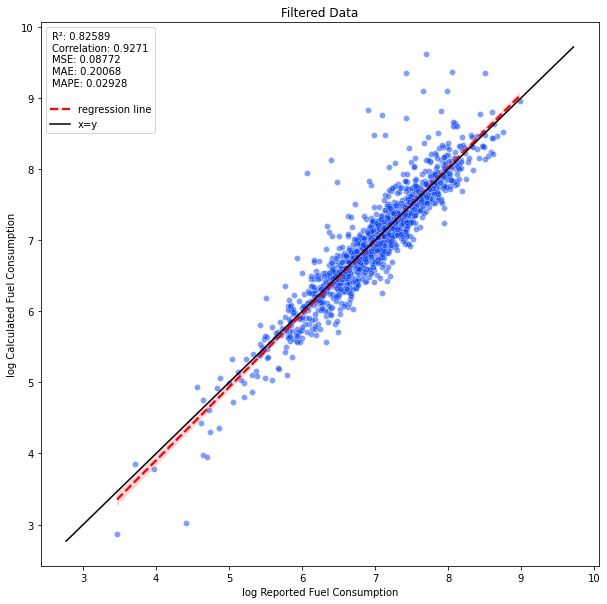

In [99]:
stats_filtered = calculate_stats('log_report_fc', 'log_cal_fc', df_ml, validation_stats)
two_way_plot(
    'log_report_fc',
    'log_cal_fc',
    df_ml,
    title='Filtered Data',
    xlabel='log Reported Fuel Consumption',
    ylabel='log Calculated Fuel Consumption',
    legend_title=create_legend_title(stats_filtered),
    regline=True,
    savepath=plotpath + fileprefix + 'twoway_fc_filtered.png')

#### Scatter plot of reported vs calculated fuel consumption by year

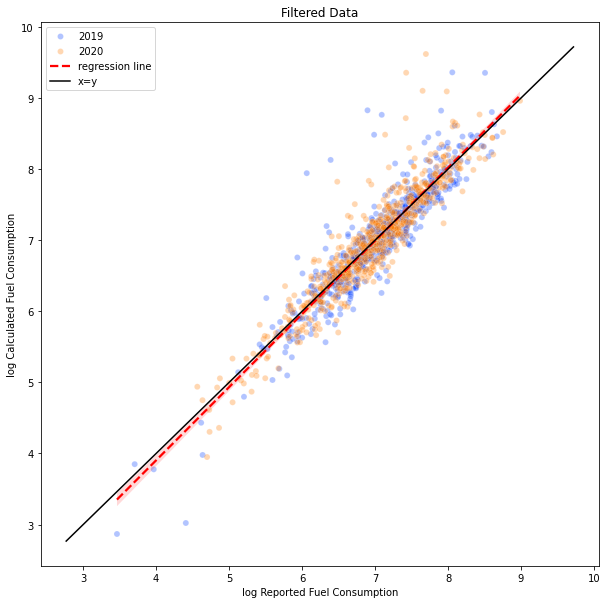

In [100]:
two_way_plot(
    'log_report_fc',
    'log_cal_fc',
    df_ml,
    hue='year_str',
    alpha=0.3,
    title='Filtered Data',
    xlabel='log Reported Fuel Consumption',
    ylabel='log Calculated Fuel Consumption',
    regline=True,
    savepath=plotpath + fileprefix + 'twoway_fcbyyear_filtered.png')

##### Histogram of residuals

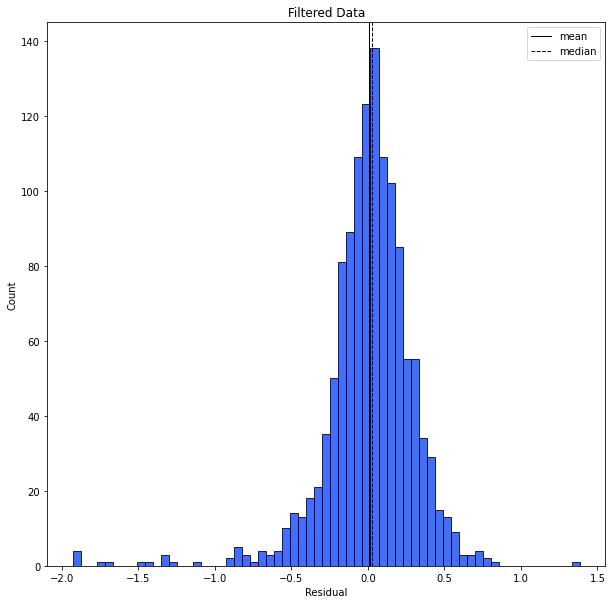

In [101]:
plt.figure(figsize=(10, 10))
sns.histplot(data=df_ml, x='residual', kde=False)
plt.title('Filtered Data')
plt.xlabel('Residual')
plt.axvline(df_ml['residual'].mean(), color='black', linestyle='solid', linewidth=1, label='mean')
plt.axvline(df_ml['residual'].median(), color='black', linestyle='dashed', linewidth=1, label='median')
plt.legend()
plt.savefig(plotpath + fileprefix + 'hist_residual_filtered.png')
plt.show()


##### Histogram of residuals by year

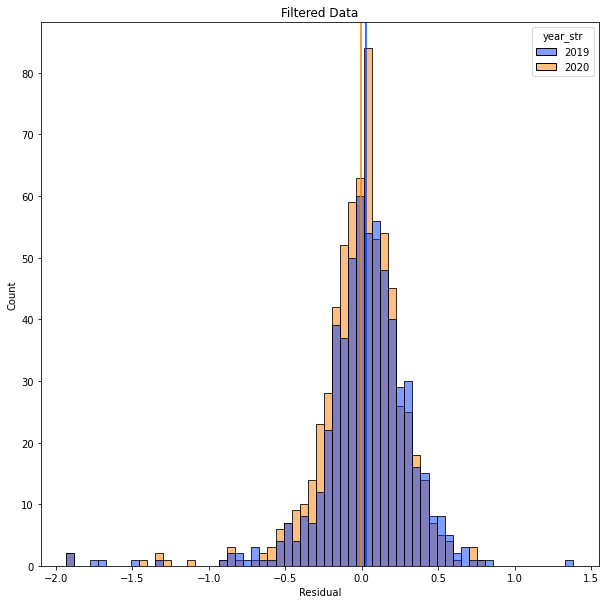

In [102]:
plt.figure(figsize=(10, 10))
sns.histplot(data=df_ml, x='residual', hue='year_str', alpha=0.5, kde=False)
hue_values = df_ml['year'].unique()
color_map = dict(zip(hue_values, sns.color_palette()))
for year, color in color_map.items():
    plt.axvline(df_ml[df_ml['year'] == year]['residual'].mean(), color=color)
plt.title('Filtered Data')
plt.xlabel('Residual')
plt.savefig(plotpath + fileprefix + 'hist_residualbyyear_filtered_.png')
plt.show()

## Feature Selection


### Manually Selected Features


In [103]:
features_dict = {
    'm1' : [
        'Draught..m.',   # Ship draught specification
        'HP.Total.Propulsion', # Total ship propulsion power
        'Service.Speed..knots.', # Nominal ship speed
        'LOA..m.', # Length of ship
        'Operational.Speed..knots.', # Average observed travel speed (from WFR)
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        'Ballast.Cap..cu.m.', # Ballast tank capacity
        'Bale.Capacity..cu.m.', # Bale capacity
        'LBP..m.', # Length between perpendiculars
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        'West.Coast.Africa.Deployment..Time.in.Last.12.Months....', # snapshot in time, value from WFR
        'EU.distance', # Annual distance travelled (EU trips) reported in MRV
        'distance_sum', # Calculated distance travelled (EU trips) from our AIS data
        'work_sum', # Calculated work done (EU trips) from our AIS data
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        'ME_W_ref_first', # Main engine power from WFR
        't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum', # sum[(v/v_ref)], annual sum of instantaneous values from AIS data
        'age', # Yearly age of ship (observed year - built year)
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'Size.Category' # Ship size category from WFR
        ],
    'm1a' : [ # remove EU.distance because MRV reported variable
        'Draught..m.',   # Ship draught specification
        'HP.Total.Propulsion', # Total ship propulsion power
        'Service.Speed..knots.', # Nominal ship speed
        'LOA..m.', # Length of ship
        'Operational.Speed..knots.', # Average observed travel speed (from WFR)
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        'Ballast.Cap..cu.m.', # Ballast tank capacity
        'Bale.Capacity..cu.m.', # Bale capacity
        'LBP..m.', # Length between perpendiculars
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        'West.Coast.Africa.Deployment..Time.in.Last.12.Months....', # snapshot in time, value from WFR
        'distance_sum', # Calculated distance travelled (EU trips) from our AIS data
        'work_sum', # Calculated work done (EU trips) from our AIS data
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        'ME_W_ref_first', # Main engine power from WFR
        't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum', # sum[(v/v_ref)], annual sum of instantaneous values from AIS data
        'age', # Yearly age of ship (observed year - built year)
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'Size.Category' # Ship size category from WFR
        ],
    'm1b' : [ # remove EU.distance because MRV reported variable, remove West coast deployment, bale capacity, ballast capacity (odd, missings), add dwt, longest_jump, and port_frac
        'Draught..m.',   # Ship draught specification
        'HP.Total.Propulsion', # Total ship propulsion power
        'Service.Speed..knots.', # Nominal ship speed
        'LOA..m.', # Length of ship
        'Operational.Speed..knots.', # Average observed travel speed (from WFR)
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        'LBP..m.', # Length between perpendiculars
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message
        'distance_sum', # Calculated distance travelled (EU trips) from our AIS data
        'work_sum', # Calculated work done (EU trips) from our AIS data
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        'ME_W_ref_first', # Main engine power from WFR
        't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum', # sum[(v/v_ref)], annual sum of instantaneous values from AIS data
        'age', # Yearly age of ship (observed year - built year)
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'Size.Category', # Ship size category from WFR
        'longest_jump',
        'port_frac',
        'Dwt'
        ],
    'm2' : [
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'distance_sum', # Calculated distance travelled (EU trips) from our AIS data
        'work_sum', # Calculated work done (EU trips) from our AIS data
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        # 't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        # 'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum' # sum[(v/v_ref)], annual sum of instantaneous values from AIS data
        ],
    'm2a' : [ # add cal_fc
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'distance_sum', # Calculated distance travelled (EU trips) from our AIS data
        'work_sum', # Calculated work done (EU trips) from our AIS data
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        # 't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        # 'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum', # sum[(v/v_ref)], annual sum of instantaneous values from AIS data

        'cal_fc'
        ],
    'm2b' : [ # remove everything used to directly calculate cal_fc
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'distance_sum', # Calculated distance travelled (EU trips) from our AIS data
        'work_sum', # Calculated work done (EU trips) from our AIS data
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        
        ],
    'm2c' : [ # exhaustive components of admiralty formula
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'distance_sum', # Calculated distance travelled (EU trips) from our AIS data
        'work_sum', # Calculated work done (EU trips) from our AIS data
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum' # sum[(v/v_ref)], annual sum of instantaneous values from AIS data
        ],
    'm3' : [
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'distance_sum', # Calculated distance travelled (EU trips) from our AIS data
        'work_sum', # Calculated work done (EU trips) from our AIS data
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations
        'MRV.method.a',
        'MRV.method.b',
        'MRV.method.c',
        'MRV.method.d',
        'MRV.verifier.country',
        'MRV.verifier.name',
        
        ## Admiralty formula components
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        # 't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        # 'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum' # sum[(v/v_ref)], annual sum of instantaneous values from AIS data
        ],
    'm4a' : [ # only cal_fc and distance
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'cal_fc'
        ],
    'm4ad' : [ # only cal_fc and no distance
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'cal_fc',

        ## Distance
        'distance_sum'
        ],
    'm4b' : [ # only work_sum and no distance
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'work_sum'
        ],
'm4bd' : [ # only work_sum and distance
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'cal_fc',

        ## Distance
        'distance_sum'
        ],
'm4cd' : [ # components and distance
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        # 't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        # 't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        # 'v_over_v_ref_without_n_sum' # sum[(v/v_ref)], annual sum of instantaneous values from AIS data

        ## Distance
        'distance_sum'
        ],
    'm4dd' : [ # kitchen sink
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum', # sum[(v/v_ref)], annual sum of instantaneous values from AIS data
        'cal_fc',

        ## Distance
        'distance_sum'
        ],
    'm4ed' : [ # only components not direclty in cal_fc, cal_fc,  and distance
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum', # sum[(v/v_ref)], annual sum of instantaneous values from AIS data
        'cal_fc',
        
        ## Distance
        'distance_sum'
        ]
}

ordinal_cols_dict = {
    'm1' : ['Size.Category'],
    'm1a' : ['Size.Category'],
    'm1b' : ['Size.Category'],
    'm2' : ['Size.Category'],
    'm2a' : ['Size.Category'],
    'm2b' : ['Size.Category'],
    'm2c' : ['Size.Category'],
    'm3' : ['Size.Category'],
    'm4a' : ['Size.Category'],
    'm4ad' : ['Size.Category'],
    'm4b' : ['Size.Category'],
    'm4bd' : ['Size.Category'],
    'm4cd' : ['Size.Category'],
    'm4dd' : ['Size.Category'],
    'm4ed' : ['Size.Category']
}

# Define category ordering
ordinal_encoding_cat_dict = {
    'Size.Category' : ['Capesize', 'Panamax', 'Handymax', 'Handysize']
}

indicator_cols_dict = {
    'm1' : [],
    'm1a' : [],
    'm1b' : [],
    'm2' : [],
    'm2a' : [],
    'm2b' : [],
    'm2c' : [],
    'm3' : ['MRV.method.a', 'MRV.method.b', 'MRV.method.c', 'MRV.method.d'],
    'm4a' : [],
    'm4ad' : [],
    'm4b' : [],
    'm4bd' : [],
    'm4cd' : [],
    'm4dd' : [],
    'm4ed' : []
}

cat_cols_dict = {
    'm1' : [],
    'm1a' : [],
    'm1b' : [],
    'm2' : [],
    'm2a' : [],
    'm2b' : [],
    'm2c' : [],
    'm3' : ['MRV.verifier.country', 'MRV.verifier.name'],
    'm4a' : [],
    'm4ad' : [],
    'm4b' : [],
    'm4bd' : [],
    'm4cd' : [],
    'm4dd' : [],
    'm4ed' : []
}

numnonneg_cols_dict = {
    'm1' : list((set(features_dict['m1']) - set(ordinal_cols_dict['m1']) - set(indicator_cols_dict['m1']) - set(cat_cols_dict['m1']))),
    'm1a' : list((set(features_dict['m1a']) - set(ordinal_cols_dict['m1a']) - set(indicator_cols_dict['m1a']) - set(cat_cols_dict['m1a']))),
    'm1b' : list((set(features_dict['m1b']) - set(ordinal_cols_dict['m1b']) - set(indicator_cols_dict['m1b']) - set(cat_cols_dict['m1b']))),
    'm2' : list((set(features_dict['m2']) - set(ordinal_cols_dict['m2']) - set(indicator_cols_dict['m2']) - set(cat_cols_dict['m2']))),
    'm2a' : list((set(features_dict['m2a']) - set(ordinal_cols_dict['m2a']) - set(indicator_cols_dict['m2a']) - set(cat_cols_dict['m2a']))),
    'm2b' : list((set(features_dict['m2b']) - set(ordinal_cols_dict['m2b']) - set(indicator_cols_dict['m2b']) - set(cat_cols_dict['m2b']))),
    'm2c' : list((set(features_dict['m2c']) - set(ordinal_cols_dict['m2c']) - set(indicator_cols_dict['m2c']) - set(cat_cols_dict['m2c']))),
    'm3' : list((set(features_dict['m3']) - set(ordinal_cols_dict['m3']) - set(indicator_cols_dict['m3']) - set(cat_cols_dict['m3']))),
    'm4a' : list((set(features_dict['m4a']) - set(ordinal_cols_dict['m4a']) - set(indicator_cols_dict['m4a']) - set(cat_cols_dict['m4a']))),
    'm4ad' : list((set(features_dict['m4ad']) - set(ordinal_cols_dict['m4ad']) - set(indicator_cols_dict['m4ad']) - set(cat_cols_dict['m4ad']))),
    'm4b' : list((set(features_dict['m4b']) - set(ordinal_cols_dict['m4b']) - set(indicator_cols_dict['m4b']) - set(cat_cols_dict['m4b']))),
    'm4bd' : list((set(features_dict['m4bd']) - set(ordinal_cols_dict['m4bd']) - set(indicator_cols_dict['m4bd']) - set(cat_cols_dict['m4bd']))),
    'm4cd' : list((set(features_dict['m4cd']) - set(ordinal_cols_dict['m4cd']) - set(indicator_cols_dict['m4cd']) - set(cat_cols_dict['m4cd']))),
    'm4dd' : list((set(features_dict['m4dd']) - set(ordinal_cols_dict['m4dd']) - set(indicator_cols_dict['m4dd']) - set(cat_cols_dict['m4dd']))),
    'm4ed' : list((set(features_dict['m4ed']) - set(ordinal_cols_dict['m4ed']) - set(indicator_cols_dict['m4ed']) - set(cat_cols_dict['m4ed'])))
}

numneg_cols_dict = {
    'm1' : [],
    'm1a' : [],
    'm1b' : [],
    'm2' : [],
    'm2a' : [],
    'm2b' : [],
    'm2c' : [],
    'm3' : [],
    'm4a' : [],
    'm4ad' : [],
    'm4b' : [],
    'm4bd' : [],
    'm4cd' : [],
    'm4dd' : [],
    'm4ed' : []
}

### Assign feature set

In [104]:
features = features_dict[feature_set]
ordinal_cols = ordinal_cols_dict[feature_set]
indicator_cols = indicator_cols_dict[feature_set]
cat_cols = cat_cols_dict[feature_set]
numnonneg_cols = numnonneg_cols_dict[feature_set]
numneg_cols = numneg_cols_dict[feature_set]

#### Check how many missing for each feature

In [105]:
missing_frac = df_ml[features].isna().sum()/len(df_ml)
print('Missing Fraction (if non-zero):')
print(missing_frac[missing_frac > 0])

Missing Fraction (if non-zero):
TPC    0.152070
NT     0.002389
dtype: float64


### Set variables for ml training

In [106]:
y = df_ml['log_report_fc']
X = df_ml[features + ['log_report_fc', 'log_cal_fc']]

## Models

In [107]:
mdl_df = tribble(
    ['model',    'class_name',                 'name',                    'type',  'scaling'],
     'gb',       'GradientBoostingRegressor',  'Gradient Boosting',       'tree',   False,
     'linear',   'LinearRegression',           'Linear Regression',       'linear', False,
     'lasso',    'Lasso',                      'Lasso',                   'linear', True,
     'ridge',    'Ridge',                      'Ridge',                   'linear', True,
     'rf',       'RandomForestRegressor',      'Random Forest',           'tree',   False,
     'cb',       'CatBoostRegressor',          'Cat Boost',               'tree',   False,
    #  'lgbm',     'LGBMRegressor',              'Light Gradient Boosting', 'tree',   False,
    #  'xgb',      'XGBRegressor',           'tree',   False,
).set_index('model')
mdl_df.to_csv(trackeddatapath + fileprefix + 'mdl_settings.csv')
mdl_df

,class_name,name,type,scaling
model,,,,
gb,GradientBoostingRegressor,Gradient Boosting,tree,False
linear,LinearRegression,Linear Regression,linear,False
lasso,Lasso,Lasso,linear,True
ridge,Ridge,Ridge,linear,True


## Pre-processing

### Imputation, Tranformation, Scaling

In [108]:
median_imputer = SimpleImputer(strategy='median')
missing_string = 'missing'
impute_as_missing = SimpleImputer(strategy='constant', fill_value=missing_string)

# setting categories manually is necessary for prediction in using the kfold evaluation loop
ind_to_encode = [X[col].fillna('missing').unique() for col in indicator_cols]
ind_encoder = OneHotEncoder(categories=ind_to_encode)
ind_encoder_nonregularized = OneHotEncoder(categories=ind_to_encode, drop='first')

cat_to_encode = [X[col].fillna('missing').unique() for col in cat_cols]
cat_encoder = OneHotEncoder(categories=cat_to_encode)
cat_encoder_nonregularized = OneHotEncoder(categories=cat_to_encode, drop='first')

log_transformer = FunctionTransformer(np.log1p, validate=True)
ordinal_transformer = make_pipeline(OrdinalEncoder(categories=[values for values in ordinal_encoding_cat_dict.values()]))

scaler = StandardScaler()

# Pipelines for numerical
impute = Pipeline(steps=[('impute', median_imputer)])

impute_transform = Pipeline(steps=[
    ('impute', median_imputer),
    ('transform', log_transformer)])

impute_scale = Pipeline(steps=[
    ('impute', median_imputer),
    ('scale', scaler)])

impute_transform_scale = Pipeline(steps=[
    ('impute', median_imputer),
    ('transform', log_transformer),
    ('scale', scaler)])

# Pipelines for indicator
ind_impute_encode = Pipeline(steps=[
    ('impute', impute_as_missing),
    ('encode', ind_encoder)])

ind_impute_encode_nonregularized = Pipeline(steps=[
    ('impute', impute_as_missing),
    ('encode', ind_encoder_nonregularized)])

# Pipelines for categorical
cat_impute_encode = Pipeline(steps=[
    ('impute', impute_as_missing),
    ('encode', cat_encoder)])

cat_impute_encode_nonregularized = Pipeline(
    steps=[('impute', impute_as_missing),
           ('encode', cat_encoder_nonregularized)])

### Column Transformers

In [109]:
# scaling not required for tree-based models
preprocessor_scaling = ColumnTransformer(
    transformers=[
        ('numeric_nonneg', impute_transform_scale, numnonneg_cols),
        ('numeric_neg', impute_scale, numneg_cols),
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('indicator', ind_impute_encode, indicator_cols),
        ('categorical', cat_impute_encode, cat_cols)
        ])

preprocessor_noscaling = ColumnTransformer(
    transformers=[
        ('numeric_nonneg', impute_transform, numnonneg_cols), # or with scaling
        ('numeric_neg', impute, numneg_cols), # or with scaling
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('indicator', ind_impute_encode, indicator_cols),
        ('categorical', cat_impute_encode, cat_cols)
        ])

# drops one category of onehot encoded categorical variables (only used for linreg)
preprocessor_noscaling_drop = ColumnTransformer(
    transformers=[
        ('numeric_nonneg', impute_transform, numnonneg_cols), # or with scaling
        ('numeric_neg', impute, numneg_cols), # or with scaling
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('indicator', ind_impute_encode_nonregularized, indicator_cols),
        ('categorical', cat_impute_encode_nonregularized, cat_cols)
        ])


### Check pre-processing visually


#### Plot histograms or processed variables


In [110]:
# TODO: apply columntransformer to X and y
# df_transformed = pd.DataFrame(mdl_gb_original[0].transform(X),
#                               columns = features_m1)
# # %%
# col_to_plot = features_m1[23]
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].hist(df_ml_train[col_to_plot])
# ax[0].axvline(df_ml_train[col_to_plot].median(), color='black', linestyle='solid', linewidth=1, label='mean')
# ax[0].set_title('Original')
# ax[1].hist(df_transformed[col_to_plot])
# ax[1].axvline(df_transformed[col_to_plot].median(), color='black', linestyle='solid', linewidth=1, label='mean')
# ax[1].set_title('Imputed & Transformed')
# fig.suptitle(col_to_plot)
# plt.show()

### Check encoding

In [111]:
# preprocessor_test = ColumnTransformer(
#     transformers=[
#         # ('indicator', ind_impute_encode, indicator_cols),
#         # ('categorical', cat_impute_encode, cat_cols),
#         ('indicator', ind_impute_encode_nonregularized, indicator_cols),
#         ('categorical', cat_impute_encode_nonregularized, cat_cols)
#         ],
#     sparse_threshold=0)

# transform_test = pd.DataFrame(
#     preprocessor_test.fit_transform(df_ml[indicator_cols + cat_cols]),
#     columns=preprocessor_test.get_feature_names_out())
# transform_test.loc[:, transform_test.columns.str.contains('.a')].head()

In [112]:
# df_ml.loc[:, indicator_cols + cat_cols]

### Base Parameters

In [113]:
mdl_base_dict = {
    'gb': {
        'n_estimators': 2000,
        'learning_rate': 0.1,
        'max_depth': 3,
        'max_features': 'sqrt',
        'min_samples_leaf': 20,
        'loss': 'squared_error',
        'min_samples_split': 20,
        'warm_start': True
    },
    'linear': {},
    'lasso': {
        'alpha': 0.01,
    },
    'ridge': {
        'alpha': 0.01,
    },
    'rf': {
        'n_estimators': 200,
        'max_depth': 10,
        # 'max_features': 'sqrt',
        # 'min_samples_leaf': 20,
        # 'min_samples_split': 20,
    },
    'cb': {
        'verbose': 0
    },
    'lgbm': {
        'verbose': 1
    },
    'xgb': {} 
}


mdl_df['base_params'] = [mdl_base_dict.get(mdl) for mdl in mdl_df.index]

## Estimators

In [114]:
mdl_df['estimator'] = mdl_df.apply(lambda row: make_estimator(row['scaling'], row['class_name'], row['base_params']), axis=1)

## Test base parameters

In [115]:
for model in mdl_df.index:
    mdl_df.loc[model, 'estimator'].fit(X, y)

#### Fuel Consumption

In [116]:
mdl_df['base_fc_stats'] = mdl_df.apply(
    lambda row: calculate_stats(
        X.log_report_fc,
        row['estimator'].predict(X),
        stats=validation_stats),
    axis=1)
compare_base_fc_df = model_stats_comparison_table('base_fc_stats', 'base_params', 'estimator', mdl_df).sort_values('r2', ascending=False)
compare_base_fc_df.to_csv(trackeddatapath + fileprefix + 'base_fc.csv')
compare_base_fc_df

,class_name,r2,corr,mse,mae,mape,params
model,,,,,,,
gb,GradientBoostingRegressor,0.998240,0.999124,0.000887,0.022336,0.003261,"{'learning_rate': 0.1, 'loss': 'squared_error'..."
linear,LinearRegression,0.967500,0.983616,0.016374,0.096605,0.014267,{}
ridge,Ridge,0.967500,0.983616,0.016374,0.096605,0.014267,{'alpha': 0.01}
lasso,Lasso,0.965673,0.982879,0.017294,0.100065,0.014768,{'alpha': 0.01}


In [117]:
mdl_df.to_pickle(datapath + fileprefix + model_df_filename + '_base.pkl')

In [118]:
print(f"Test base parameters complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")

Test base parameters complete at 2024-03-23 23:23:09, after 0.1 minutes



## Hyperparameter Tuning: 5-fold CV, Grid Search

In [119]:
mdl_df = pd.read_pickle(datapath + fileprefix + model_df_filename + '_base.pkl')

### Define search grids

In [120]:
mdl_gs_dict = {
    'gb': {
        'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 4, 5, 6]
    },
    'linear': {},
    'lasso': {
        'alpha': [5e-3, 1e-2, 0.1, 1, 10, 100],
    },
    'ridge': {
        'alpha': [5e-3, 1e-2, 0.1, 1, 10, 100, 1000, 10000, 100000],
    },
    'rf': {
        'n_estimators': [200, 700, 1000],
        'max_depth': [10, 30, 50],
        # 'max_features': ['sqrt'],
        # 'min_samples_leaf': [20],
        # 'min_samples_split': [20],
    },
    'cb': {
        'learning_rate' : [0.01, 0.05, 0.1],
        'depth': [6, 8 ,10],
        # 'iterations': [10, 50, 500],
        'l2_leaf_reg': [1, 7, 15]
    },
    'lgbm': {
        'num_leaves': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'learning_rate': [0.005, 0.01, 0.1, 0.2, 0.3],
        'num_iterations': [10, 50, 100, 500, 1000, 5000, 10000],
        'max_bin': [255, 300, 500, 1000],
        'boosting' : ['gbdt', 'dart'],
    },
    # 'xgb': 
}


mdl_df['gs_params'] = [mdl_gs_dict.get(mdl) for mdl in mdl_df.index]

In [121]:
# for quicker testing
# mdl_gs_dict = {
#     'gb': {
#         'learning_rate': [0.01],
#         'max_depth': [3, 4]
#     },
#     'linear': {},
#     'lasso': {
#         'alpha': [0.1],
#     },
#     'ridge': {
#         'alpha': [0.1],
#     },
#     'rf': {
#         'n_estimators': [200],
#         'max_depth': [10],
#         # 'max_features': ['sqrt'],
#         # 'min_samples_leaf': [20],
#         # 'min_samples_split': [20],
#     },
#     'cb': {
#         'depth': [6, 8],
#         'iterations': [30],
#         'l2_leaf_reg': [7]
#     },
#     'lgbm': {
#         'num_leaves': [50],
#         'learning_rate': [0.01, 0.1],
#         'num_iterations': [100],
#         'max_bin': [500],
#         'boosting' : ['gbdt', 'dart']
#     },
#     # 'xgb': 
# }


# mdl_df['gs_params'] = [mdl_gs_dict.get(mdl) for mdl in mdl_df.index]

In [122]:
# add model class_name prefix to parameter names
mdl_df['gs_params_prefix'] = mdl_df.apply(lambda row: {row['class_name'].lower() + '__' + k: v for k, v in row['gs_params'].items()}, axis=1)
mdl_df[['gs_params', 'gs_params_prefix']]

,gs_params,gs_params_prefix
model,,
gb,"{'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2...",{'gradientboostingregressor__learning_rate': [...
linear,{},{}
lasso,"{'alpha': [0.005, 0.01, 0.1, 1, 10, 100]}","{'lasso__alpha': [0.005, 0.01, 0.1, 1, 10, 100]}"
ridge,"{'alpha': [0.005, 0.01, 0.1, 1, 10, 100, 1000,...","{'ridge__alpha': [0.005, 0.01, 0.1, 1, 10, 100..."


### Fit grid search

In [123]:
mdl_df['grid_search'] = mdl_df.apply(
    lambda row: GridSearchCV(
        row['estimator'],
        row['gs_params_prefix'],
        cv=cv_folds,
        scoring=cv_scoring,
        n_jobs=max_cores,
        verbose=1),
        axis=1)

for model in mdl_df.index:
    mdl_df.loc[model, 'grid_search'].fit(X, y)
    
mdl_df['best_estimator'] = mdl_df.apply(lambda row: row['grid_search'].best_estimator_, axis=1)

# Column of best parameters chosen from grid search CV (with short names)
mdl_df['best_params'] = mdl_df.apply(lambda row: extract_filter_params(row, 'best_estimator', 'gs_params'), axis=1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


### Grid search results

#### Fuel Consumption

In [124]:
mdl_df['best_fc_stats'] = mdl_df.apply(
    lambda row: calculate_stats(
        X.log_report_fc,
        row['best_estimator'].predict(X),
        stats=validation_stats),
    axis=1)
compare_best_fc_df = model_stats_comparison_table('best_fc_stats', 'best_params', 'best_estimator', mdl_df).sort_values('r2', ascending=False)
compare_best_fc_df.to_csv(trackeddatapath + fileprefix + 'best_fc.csv')
compare_best_fc_df

,class_name,r2,corr,mse,mae,mape,params
model,,,,,,,
gb,GradientBoostingRegressor,0.989431,0.994730,0.005325,0.054174,0.007998,"{'learning_rate': 0.01, 'max_depth': 5}"
linear,LinearRegression,0.967500,0.983616,0.016374,0.096605,0.014267,{}
ridge,Ridge,0.967195,0.983464,0.016527,0.097010,0.014316,{'alpha': 10}
lasso,Lasso,0.966621,0.983219,0.016817,0.098435,0.014536,{'alpha': 0.005}


In [125]:
mdl_df.to_pickle(datapath + fileprefix + model_df_filename + '_best.pkl')

#### Manual checks

In [126]:
# compare_best_fc_df.loc['rf', 'params']

In [127]:
# cv_results_check = pd.DataFrame(mdl_df.loc['rf', 'grid_search'].cv_results_)

# cv_results_check = cv_results_check.loc[:, cv_results_check.columns[cv_results_check.columns.str.contains('param')].tolist() + ['mean_test_score', 'std_test_score', 'rank_test_score']]

# cv_results_check.sort_values('rank_test_score')

In [128]:
print(f"Hyperparameter tuning complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")

Hyperparameter tuning complete at 2024-03-23 23:24:39, after 1.6 minutes


takes around 25 minutes total

In [129]:
# processing time (seconds) of best estimators
mdl_df.loc[:, 'grid_search'].apply(lambda x: x.cv_results_['mean_fit_time'][x.cv_results_['rank_test_score'] == 1][0])

model
gb        5.593184
linear    0.013586
lasso     0.018946
ridge     0.013858
Name: grid_search, dtype: float64

## Evaluation of Tuned Models


In [130]:
mdl_df = pd.read_pickle(datapath + fileprefix + model_df_filename + '_best.pkl')
# mdl_df

### Leave-one-out

In [131]:
# loo = LeaveOneOut()
# mdl_df['eval_prediction'] = mdl_df.apply(lambda row: loo_evaluation(row['best_estimator']), axis=1)
# mdl_df.to_pickle(datapath + fileprefix + model_df_filename + '_loo.pkl')

### K-fold

In [132]:
kf = KFold(n_splits=eval_folds, shuffle=False)
# expected repeated evaluation time in minutes
print(f"Estimated minutes to complete {eval_folds} folds: {mdl_df.loc[:, 'grid_search'].apply(lambda x: x.cv_results_['mean_fit_time'][x.cv_results_['rank_test_score'] == 1][0]*eval_folds/60)}")

# create list so can stop part way through, assign partially complete
eval_prediction = [np.NAN for _ in range(len(mdl_df))]
for i, model in enumerate(mdl_df.index.to_list()):
    eval_prediction[i] = kfold_evaluation(mdl_df.loc[model]['best_estimator'], model)


Estimated minutes to complete 100 folds: model
gb        9.321974
linear    0.022644
lasso     0.031576
ridge     0.023096
Name: grid_search, dtype: float64
Starting evaluating gb at: 2024-03-23 23:24:39
Starting evaluating linear at: 2024-03-23 23:24:46
Starting evaluating lasso at: 2024-03-23 23:24:47
Starting evaluating ridge at: 2024-03-23 23:24:50


Example runtimes:
- Starting evaluating gb at: 2024-03-19 11:44:23
- Starting evaluating linear at: 2024-03-19 11:44:29
- Starting evaluating lasso at: 2024-03-19 11:44:30
- Starting evaluating ridge at: 2024-03-19 11:44:33
- Starting evaluating rf at: 2024-03-19 11:44:35
- Starting evaluating cb at: 2024-03-19 11:51:23
- finished 11:55

In [133]:
mdl_df['eval_prediction'] = eval_prediction

# Alternative using apply (no option to stop part way)
# mdl_df['eval_prediction'] = mdl_df.apply(lambda row: kfold_evaluation(row['best_estimator'], row.name), axis=1)

mdl_df.to_pickle(datapath + fileprefix + model_df_filename + '_kf.pkl')

In [134]:
print(f"Sample splitting evaluation complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")

Sample splitting evaluation complete at 2024-03-23 23:24:52, after 1.8 minutes


## Model Performance Comparison

In [135]:
# mdl_df = pd.read_pickle(datapath + fileprefix + model_df_filename + '_loo.pkl')
mdl_df = pd.read_pickle(datapath + fileprefix + model_df_filename + '_kf.pkl')

In [136]:
mdl_df = mdl_df.dropna(subset=['eval_prediction']).copy()

### Stats FC

In [137]:
mdl_df['eval_fc_stats'] = mdl_df.apply(
    lambda row: calculate_stats(
        X.log_report_fc,
        row['eval_prediction'],
        stats=validation_stats),
    axis=1)
compare_eval_fc_df = model_stats_comparison_table('eval_fc_stats', 'best_params', 'best_estimator', mdl_df).sort_values('r2', ascending=False)
compare_eval_fc_df.to_csv(trackeddatapath + fileprefix + 'eval_fc.csv')
compare_eval_fc_df

,class_name,r2,corr,mse,mae,mape,params
model,,,,,,,
gb,GradientBoostingRegressor,0.989431,0.994730,0.005325,0.054174,0.007998,"{'learning_rate': 0.01, 'max_depth': 5}"
ridge,Ridge,0.965813,0.982760,0.017224,0.098938,0.014606,{'alpha': 10}
linear,LinearRegression,0.965808,0.982755,0.017226,0.098927,0.014616,{}
lasso,Lasso,0.965387,0.982588,0.017438,0.100065,0.014784,{'alpha': 0.005}


### Two-way plot of FC

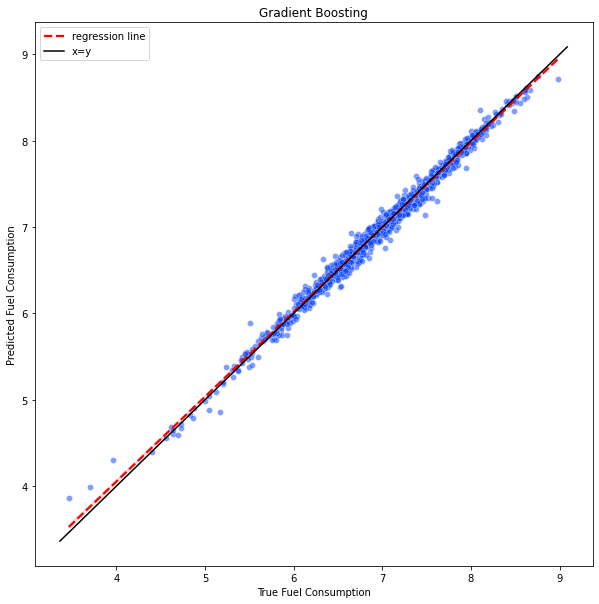

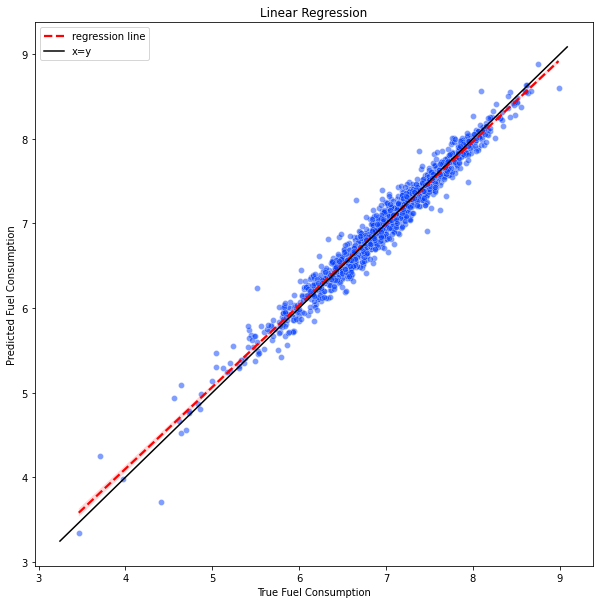

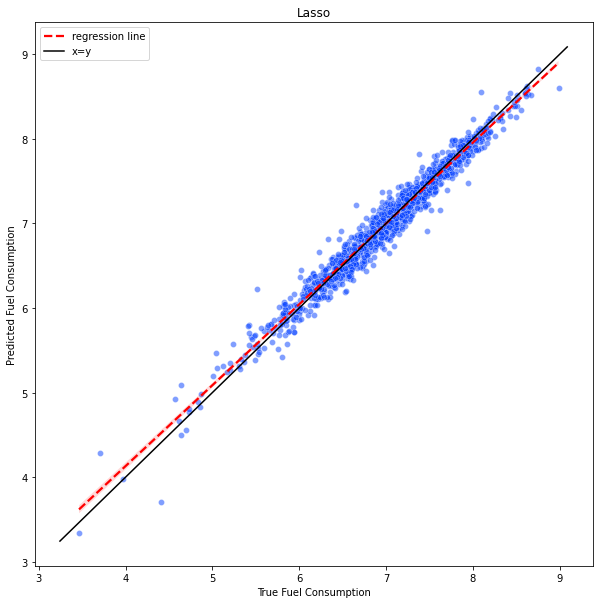

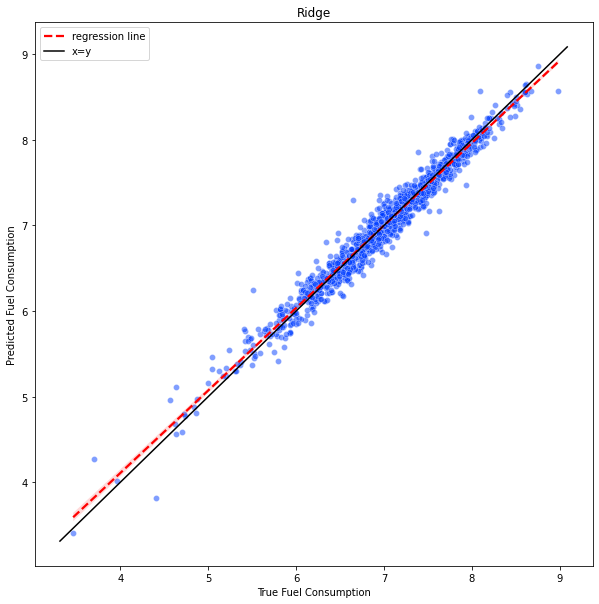

model
gb        Axes(0.125,0.125;0.775x0.755)
linear    Axes(0.125,0.125;0.775x0.755)
lasso     Axes(0.125,0.125;0.775x0.755)
ridge     Axes(0.125,0.125;0.775x0.755)
dtype: object

In [138]:
mdl_df.apply(lambda row: two_way_plot_new(X.log_report_fc, row['eval_prediction'], title=row['name'], xlabel='True Fuel Consumption', ylabel='Predicted Fuel Consumption', regline=True), axis=1)

In [139]:
mdl_df.to_pickle(datapath + fileprefix + model_df_filename + '_compare.pkl')

## Training Set Performance

In [140]:
# mdl_df = pd.read_pickle(datapath + fileprefix + model_df_filename + '_eval.pkl')
mdl_df = pd.read_pickle(datapath + fileprefix + model_df_filename + '_compare.pkl')

### Stats FC

#### Engineering Model

In [141]:
stats_eng = calculate_stats('log_report_fc', 'log_cal_fc', X, validation_stats)
stats_eng_df = pd.DataFrame(stats_eng).drop('names', axis=1).T
stats_eng_df['model'] = 'eng'
stats_eng_df = stats_eng_df.set_index('model')
stats_eng_df

,r2,corr,mse,mae,mape
model,,,,,
eng,0.825887,0.927104,0.087719,0.200678,0.029285


#### ML Models

In [142]:
for model in mdl_df.index:
    mdl_df.loc[model, 'best_estimator'].fit(X, y)

In [143]:
mdl_df['train_prediction'] = mdl_df.apply(lambda row: row['best_estimator'].predict(X), axis=1)
mdl_df['train_fc_stats'] = mdl_df.apply(
    lambda row: calculate_stats(
        X.log_report_fc,
        row['train_prediction'],
        stats=validation_stats),
    axis=1)
compare_train_fc_df = model_stats_comparison_table('train_fc_stats', 'best_params', 'best_estimator', mdl_df)
compare_train_fc_df = pd.concat([stats_eng_df, compare_train_fc_df], axis=0)
compare_train_fc_df.sort_values('r2', ascending=False)

,r2,corr,mse,mae,mape,class_name,params
model,,,,,,,
gb,0.989431,0.994730,0.005325,0.054174,0.007998,GradientBoostingRegressor,"{'learning_rate': 0.01, 'max_depth': 5}"
linear,0.967500,0.983616,0.016374,0.096605,0.014267,LinearRegression,{}
ridge,0.967195,0.983464,0.016527,0.097010,0.014316,Ridge,{'alpha': 10}
lasso,0.966621,0.983219,0.016817,0.098435,0.014536,Lasso,{'alpha': 0.005}
eng,0.825887,0.927104,0.087719,0.200678,0.029285,NaN,NaN


### Two-way plot of FC

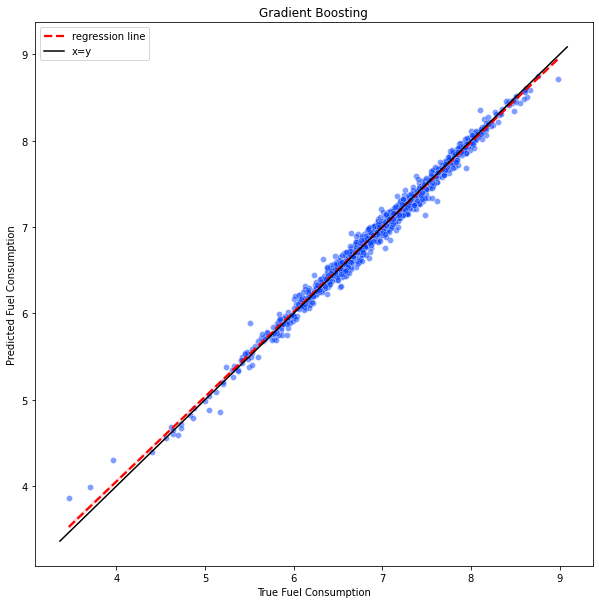

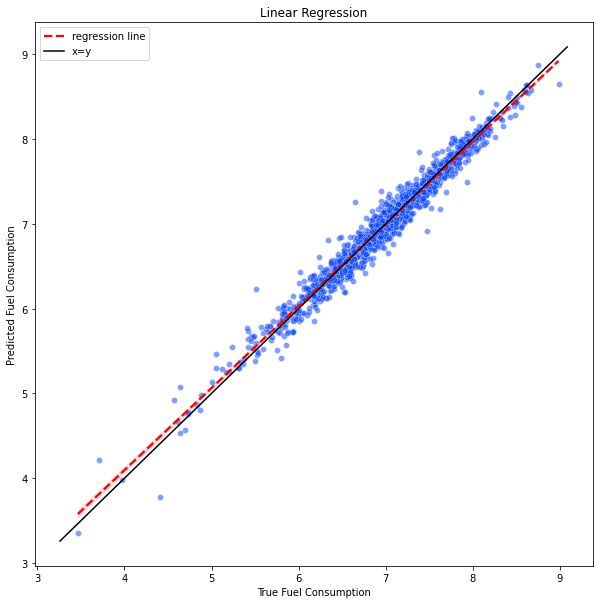

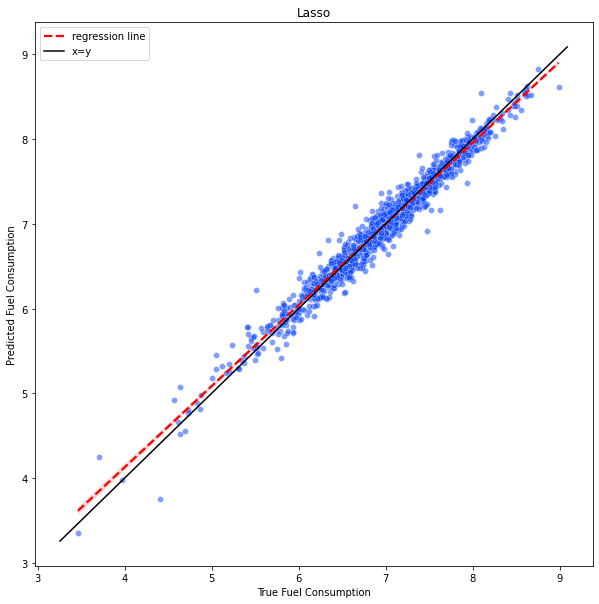

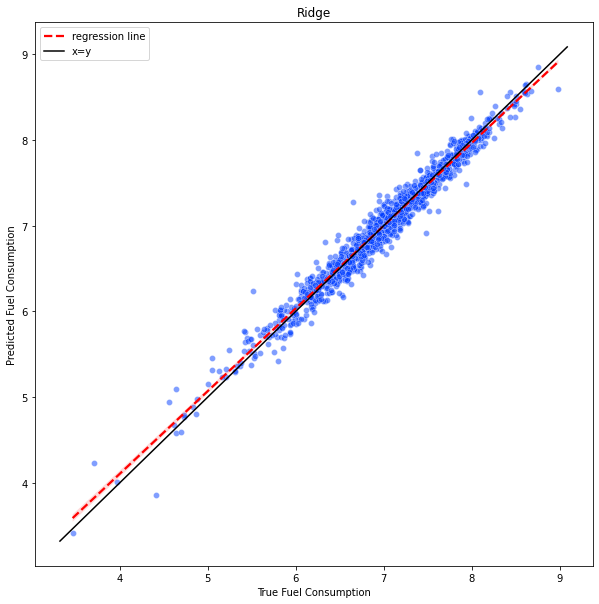

model
gb        Axes(0.125,0.125;0.775x0.755)
linear    Axes(0.125,0.125;0.775x0.755)
lasso     Axes(0.125,0.125;0.775x0.755)
ridge     Axes(0.125,0.125;0.775x0.755)
dtype: object

In [144]:
mdl_df.apply(lambda row: two_way_plot_new(X.log_report_fc, row['train_prediction'], title=row['name'], xlabel='True Fuel Consumption', ylabel='Predicted Fuel Consumption', regline=True), axis=1)

### Feature Importance

#### Permutation-based

In [145]:
mdl_df['perm_importance'] = mdl_df.apply(lambda row: permutation_importance(
    row['best_estimator'],
    X[features],
    y,
    n_repeats=10,
    random_state=0,
    n_jobs=max_cores),
    axis=1)

#### Plots

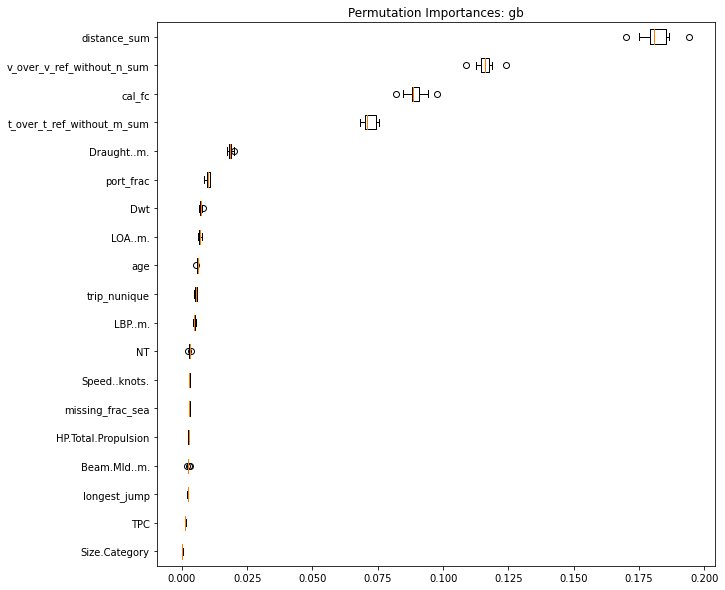

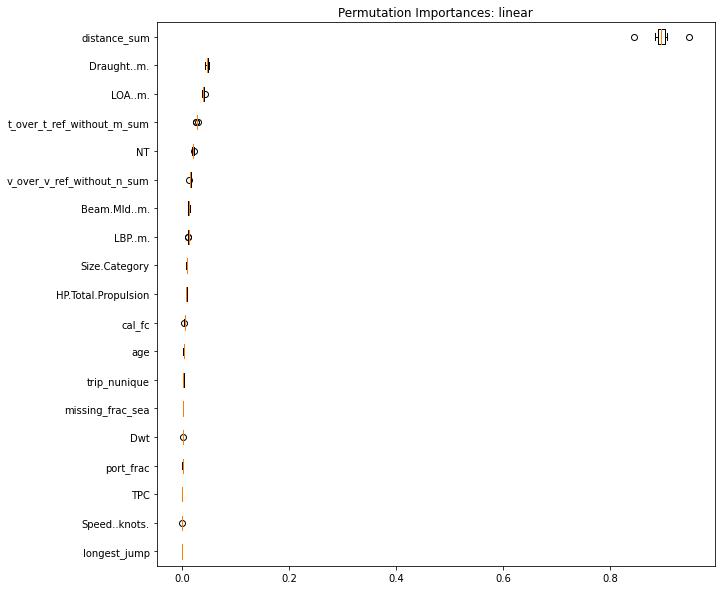

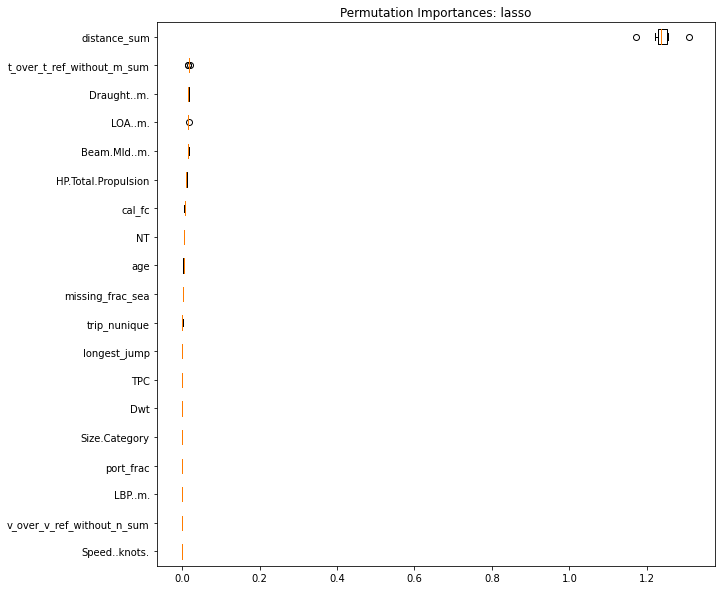

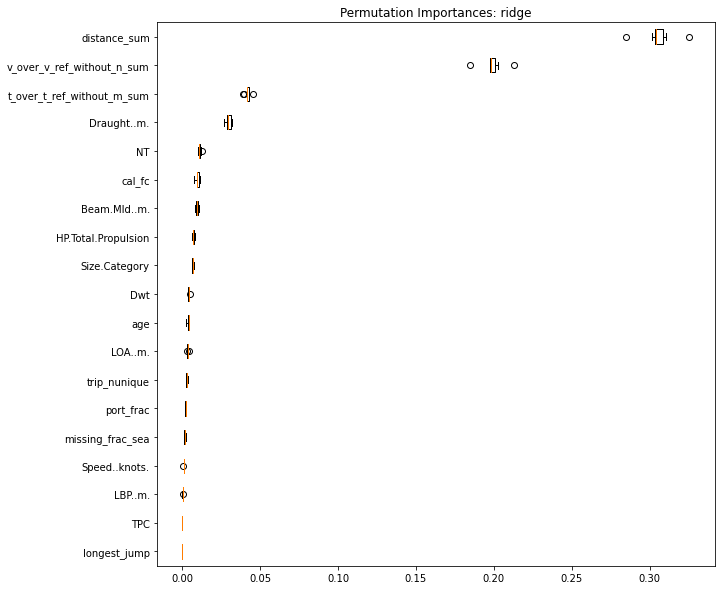

In [146]:
for model in mdl_df.index:
    FI_plot(mdl_df.loc[model, 'perm_importance'], model)

### Rank

In [147]:
FI_df = pd.DataFrame()
for model in mdl_df.index:
    FI_df = pd.concat([FI_df, pd.DataFrame(mdl_df.loc[model, 'perm_importance']['importances_mean'], columns = ['importance'], index = features).assign(model = model)], axis=0)

FI_df['rank'] = FI_df.groupby('model')['importance'].rank(ascending=False).astype(int)
FI_df = FI_df.drop(columns='importance').pivot(columns='model', values='rank')
FI_df['mean'] = FI_df.mean(axis=1)
FI_df['sd'] = FI_df.std(axis=1)
FI_df = FI_df.sort_values('mean')
FI_df.to_csv(trackeddatapath + fileprefix + 'FI.csv')
FI_df


model,gb,lasso,linear,ridge,mean,sd
distance_sum,1,1,1,1,1.00,0.000000
t_over_t_ref_without_m_sum,4,2,4,3,3.25,0.829156
Draught..m.,5,3,2,4,3.50,1.118034
v_over_v_ref_without_n_sum,2,16,6,2,6.50,5.722762
cal_fc,3,7,11,6,6.75,2.861381
LOA..m.,8,4,3,12,6.75,3.561952
NT,12,8,5,5,7.50,2.872281
Beam.Mld..m.,16,5,7,7,8.75,4.264681
HP.Total.Propulsion,15,6,10,8,9.75,3.344772
age,9,9,12,11,10.25,1.299038


In [148]:
print(f"Evaluation complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")

Evaluation complete at 2024-03-23 23:25:02, after 2.0 minutes


## Test Set Performance

### Load, explore, filter

In [149]:
df_ml_test = pd.read_csv(readdatapath + "df_ml_" + tol_type + "_test.csv", low_memory=False)

# for nicer colors when plotting
df_ml_test = df_ml_test.sort_values('year')
df_ml_test['year_str'] = df_ml_test['year'].astype(str) 

# Label as outliers according *training* set thresholds
df_ml_test['outlier'] = ~df_ml_test['residual'].between(
    raw_mean - outlier_threshold * raw_std,
    raw_mean + outlier_threshold * raw_std,
    inclusive='neither')

df_ml_test.describe(include='all')

,CVN,IMO.Number,Name,mmsi,Ex.Name,Flag.State,Operator,Owner,Group.Owner,Built.Date,...,longest_jump,missing_frac_sea,age,residual,log_report_fc,log_cal_fc,distance_difference,distance_difference_rel,year_str,outlier
count,6.950000e+02,6.950000e+02,695,6.950000e+02,307,695,597,695,695,695,...,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000,695,695
unique,NaN,NaN,695,NaN,306,41,321,381,359,226,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2
top,NaN,NaN,Spring Brave,NaN,Ikan Sembak,Marshall Is.,Oldendorff Carriers,COSCO Shipping Bulk,China COSCO Shipping,2012-06-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,False
freq,NaN,NaN,1,NaN,2,128,26,22,25,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,695,692
mean,1.639290e+07,9.510052e+06,NaN,4.399381e+08,NaN,NaN,NaN,NaN,NaN,NaN,...,2352.536824,0.156192,10.620144,0.001099,6.956954,6.955855,-73.710599,-0.010757,NaN,NaN
std,5.908711e+06,1.950239e+05,NaN,1.435145e+08,NaN,NaN,NaN,NaN,NaN,NaN,...,3703.959927,0.123994,5.307235,0.392681,0.739873,0.848021,202.735973,0.046904,NaN,NaN
min,1.229754e+07,8.116972e+06,NaN,2.055800e+08,NaN,NaN,NaN,NaN,NaN,NaN,...,48.413914,0.002315,0.000000,-6.640364,3.726657,3.440510,-499.503796,-1.003306,NaN,NaN
25%,1.604691e+07,9.395002e+06,NaN,3.110232e+08,NaN,NaN,NaN,NaN,NaN,NaN,...,175.290512,0.065602,8.000000,-0.123144,6.513230,6.478810,-205.581115,-0.018084,NaN,NaN
50%,1.615578e+07,9.522958e+06,NaN,4.772208e+08,NaN,NaN,NaN,NaN,NaN,NaN,...,408.673340,0.121403,10.000000,0.012540,7.039275,7.035539,-52.668634,-0.004823,NaN,NaN
75%,1.622344e+07,9.628192e+06,NaN,5.380091e+08,NaN,NaN,NaN,NaN,NaN,NaN,...,2913.109863,0.208612,13.000000,0.170655,7.449820,7.498314,30.046612,0.002505,NaN,NaN


In [150]:
df_ml_test['outlier'].value_counts()

outlier
False    692
True       3
Name: count, dtype: int64

### Plot raw vs. training

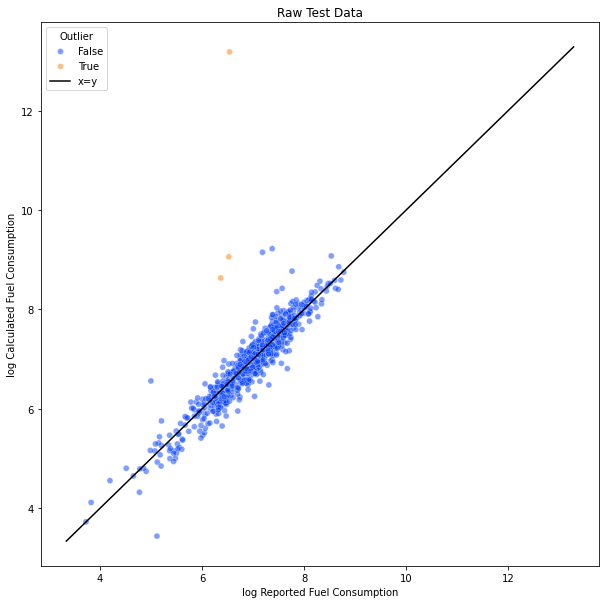

In [151]:
two_way_plot(
     'log_report_fc',
     'log_cal_fc',
     df_ml_test,
     hue='outlier',
     title='Raw Test Data',
     xlabel='log Reported Fuel Consumption',
     ylabel='log Calculated Fuel Consumption',
     legend_title='Outlier',
     regline=False)
    #  savepath=plotpath + fileprefix + 'twoway_fc_raw.png')

#### Histogram by outlier

In [152]:
print(raw_mean - outlier_threshold * raw_std)
print(raw_mean + outlier_threshold * raw_std)

-2.072164390469508
1.9601282160397033


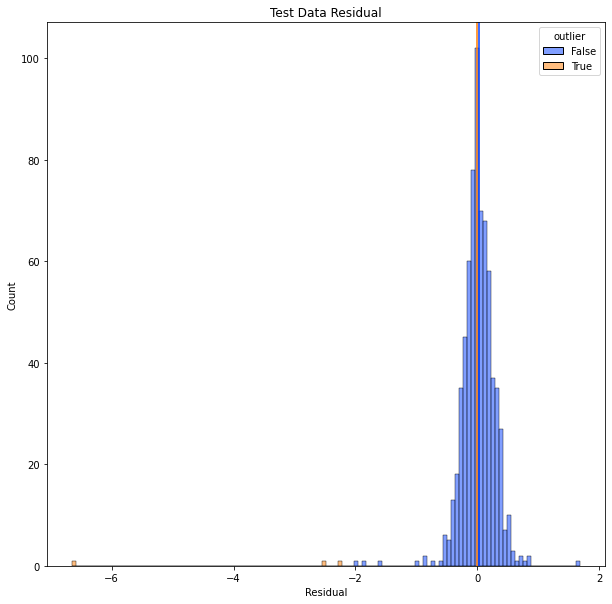

In [153]:
plt.figure(figsize=(10, 10))
sns.histplot(data=df_ml_test, x='residual', hue='outlier', alpha=0.5, kde=False)
hue_values = df_ml['year'].unique()
color_map = dict(zip(hue_values, sns.color_palette()))
for year, color in color_map.items():
    plt.axvline(df_ml[df_ml['year'] == year]['residual'].mean(), color=color)
plt.title('Test Data Residual')
plt.xlabel('Residual')
# plt.savefig(plotpath + fileprefix + 'hist_residualbyyear_filtered_.png')
plt.show()

In [154]:
df_ml_test = df_ml_test.loc[~df_ml_test['outlier']]
print(f'Filtered Data: \n observations: {len(df_ml)} \n target mean: {df_ml_test.residual.mean()} \n target sd: {df_ml_test.residual.std()}')

Filtered Data: 
 observations: 1256 
 target mean: 0.0176395584188522 
 target sd: 0.27204340559806633


### Create df of both train and test data for plotting

In [155]:
df_ml_all = pd.concat([df_ml, df_ml_test], keys=['train', 'test'])
df_ml_all.reset_index(level=0, inplace=True)
df_ml_all.rename(columns={'level_0': 'set'}, inplace=True)

### Plot filtered vs. training

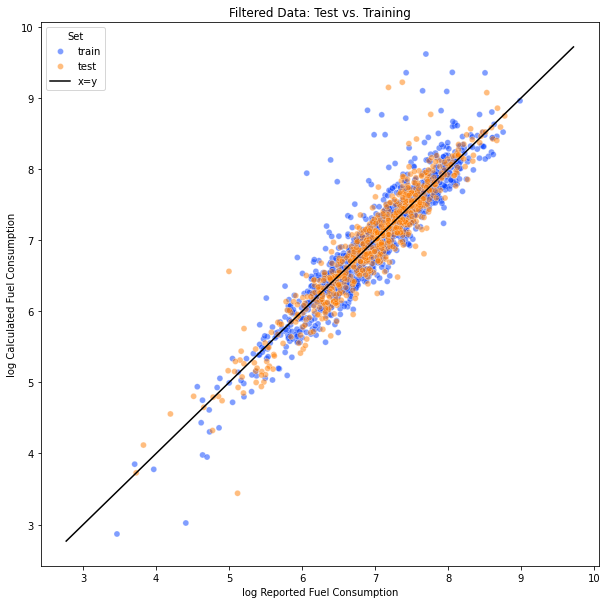

In [156]:
two_way_plot(
     'log_report_fc',
     'log_cal_fc',
     df_ml_all,
     hue='set',
     title='Filtered Data: Test vs. Training',
     xlabel='log Reported Fuel Consumption',
     ylabel='log Calculated Fuel Consumption',
     legend_title='Set',
     regline=False)
    #  savepath=plotpath + fileprefix + 'twoway_fc_raw.png')

### Performance comparison

In [157]:
mdl_df['test_prediction'] = mdl_df.apply(lambda row: row['best_estimator'].predict(df_ml_test), axis=1)


mdl_df['test_fc_stats'] = mdl_df.apply(
    lambda row: calculate_stats(
        df_ml_test.log_report_fc,
        row['test_prediction'],
        stats=validation_stats),
    axis=1)
compare_test_fc_df = model_stats_comparison_table('test_fc_stats', 'best_params', 'best_estimator', mdl_df)
compare_test_fc_df = pd.concat([stats_eng_df, compare_test_fc_df], axis=0).sort_values('r2', ascending=False)

compare_test_fc_df.to_csv(trackeddatapath + fileprefix + 'test_fc.csv')
print('Eng + ML')
compare_test_fc_df

Eng + ML


,r2,corr,mse,mae,mape,class_name,params
model,,,,,,,
linear,0.956086,0.979115,0.024063,0.109315,0.016330,LinearRegression,{}
ridge,0.955731,0.978963,0.024258,0.110023,0.016449,Ridge,{'alpha': 10}
lasso,0.955662,0.978645,0.024295,0.109170,0.016310,Lasso,{'alpha': 0.005}
gb,0.949484,0.976585,0.027681,0.119046,0.017856,GradientBoostingRegressor,"{'learning_rate': 0.01, 'max_depth': 5}"
eng,0.825887,0.927104,0.087719,0.200678,0.029285,NaN,NaN


In [158]:
print(f"Totally complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")

Totally complete at 2024-03-23 23:25:03, after 2.0 minutes
